### SemEval2019 Hyperpartisan News Detection
#### Using GloVe as document representation

In [1]:
from lxml.etree import iterparse
import xml

import numpy as np
import random
import os
random_seed = 42
seed_value = random_seed

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

import pandas as pd
import pickle

import sys
sys.path.append('/home/ruan/Documentos/git/tcc-ii-ir-features-text-mining/tool-testing/corpus_2_solution_2/')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score

from sklearn import preprocessing

from utils import *

import nltk
# nltk.download('punkt')

In [2]:
import inspect
import datetime
import logging
import pickle
import time
root_path = "/home/ruan/Documentos/git/tcc-ii-ir-features-text-mining/tool-testing/"
sys.path.insert(0, root_path)
from indextoolmanager import IndexToolManager

variable_name = 'TRAIN_CLF'
datestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up logging to file - see previous section for more details
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename=f'{root_path}logs/C2-S2-{datestr}-{variable_name}_debug.log',
                    filemode='w')
# define a Handler which writes INFO messages or higher to the sys.stderr
console = logging.StreamHandler()
console.setLevel(logging.INFO)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
# tell the handler to use this format
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger(variable_name).addHandler(console)

In [3]:
mylogger = logging.getLogger(variable_name)
handler1 = logging.FileHandler(f'{root_path}logs/{datestr}-{variable_name}.log')
handler1.setLevel(logging.INFO)
formatter = logging.Formatter(
    '%(asctime)s %(name)-12s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

handler1.setFormatter(formatter)
mylogger.addHandler(handler1)

add_ir_variables = True
ignore_first_result = False
exp_id = str(datetime.datetime.now())
tool = 'elastic'
hyperpartisan_db_name = 'hyperpartisan_split_42_bulk'
hyperpartisan_orig_db_name = 'hyperpartisan_bulk'

In [4]:
exp_dict = {
    'exp_id': exp_id,
    'tool': tool,
    'db': 'hyperpartisan',
    'db_name': hyperpartisan_db_name,
    'add_ir_variables': add_ir_variables,
    'solution_number': '2',
    'solution_name': '4_tom',
    'ir_top_k': 200,
    # 'train_input': '',
    # 'train_epochs': '',
    'ignore_first_result': ignore_first_result,
    'random_seed': random_seed,
    'classifier': '',
    'svc_C': '',
    'svc_max_iter': '',
}

testTool = IndexToolManager(
    indexName=str(hyperpartisan_db_name), top_k=exp_dict['ir_top_k'])

In [5]:
def readFiles(textFile, labelFile):
    X,y = [], []    
    with open(labelFile) as labelFile:
        xml.sax.parse(labelFile, GroundTruthHandler(y))       
    for event, elem in iterparse(textFile):
        if elem.tag == "article":
            title = elem.attrib['title']
            text = "".join(elem.itertext())
            title = cleanQuotations(title)
            text = cleanQuotations(text)
            text = cleanText(fixup(text))
            text = ' '.join(text.split()[:1000])
            X.append(title + ". " + text)
            elem.clear()
    return np.asarray(X), np.asarray(y)

In [6]:
def read_glove(path, dim):
    '''
    read the glove vectors from path with dimension dim
    '''
    df = pd.read_csv(path + 'glove.6B.' + str(dim) + 'd.txt', sep=" ", quoting=3, header=None, index_col=0)
    glove = {key: val.values for key, val in df.T.items()}
    return glove

In [7]:
# set path for data
dataPath = root_path + 'db_hyperpartisan/'
pretrained_wv_path = root_path + "corpus_2_solution_2/pretrained_wv/"

textFile = dataPath + 'articles-training-byarticle.xml'

labelFile = dataPath + "ground-truth-training-byarticle.xml"

# read in data and glove vectors
texts, labels = readFiles(textFile, labelFile)

glove = read_glove(pretrained_wv_path, 300)

# split the samples with the same seed to compare results with other methods
# id1, id2 = fixedTestSplit(labels)
id1, id2 = fixedTestSplit42(labels)

In [8]:
def gloveVectorize(glove, text):
    '''
    Find the pretrained glove vectors of the first 1000 words in the articles.
    The final vector is the average of the vectors
    '''
    ir_variables_of_this_author, time_query_list = [], []
    dim = len(glove["the"])
    if (exp_dict['add_ir_variables']):
        X = np.zeros( (len(text), dim+6) )
    else:
        X = np.zeros( (len(text), dim) )
    for text_id, t in enumerate(text):
        tmp = np.zeros((1, dim))
        # tokenize and remove stopwords
        words = customTokenize(t, rm_stopwords=True)
        words = [w for w in words if w in glove.keys()]
        for word in words:
            tmp[:] += glove[word]
        ir_variables = {}
        ir_vars_dict = []
        if (exp_dict['add_ir_variables']):
            initial = None
            final = None
            initial = time.time()
            ign_first = ignore_first_result and (text_id in id1)
            if (exp_dict['tool'] == 'arango'):
                ir_variables = testTool.arango_get_IR_variables(
                    t, 'true', ignore_first_result=ign_first)
            elif (exp_dict['tool'] == 'elastic'):
                ir_variables = testTool.elastic_get_IR_variables(
                    t, 'true', ignore_first_result=ign_first)
            elif (exp_dict['tool'] == 'zettair'):
                ir_variables = testTool.zettair_get_IR_variables(
                    t, 'true', False, ignore_first_result=ign_first)
            final = time.time()
            time_query_list.append(float(final-initial))
            ir_vars_dict = [ir_variables['CLASS_0_BM25_AVG'], ir_variables['CLASS_0_BM25_COUNT'],
            ir_variables['CLASS_0_BM25_SUM'], ir_variables['CLASS_1_BM25_AVG'],
            ir_variables['CLASS_1_BM25_COUNT'], ir_variables['CLASS_1_BM25_SUM'],
]
        X[text_id, :] = np.concatenate((tmp/len(words), ir_vars_dict), axis=None)

    result_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S.%f")
    time_query = np.mean(time_query_list)
    testTool.log_result(result_id, {
        'variable': 'TIME_QUERY',
        ** exp_dict,
        ** testTool.get_parameters(),
        'execution_type': 'training_test',
        'number_queries': str(len(time_query_list)),
        'value': str(time_query),
    })

    return X

In [9]:
glove_texts = gloveVectorize(glove, texts)

train_x = glove_texts[id1]
test_x = glove_texts[id2]
print('Train shape: ', train_x.shape)
print('Test shape: ', test_x.shape)

Train shape:  (430, 306)
Test shape:  (215, 306)


In [10]:
train_x[1:4, -6:]

array([[   59.45384922,    91.        ,  5410.300279  ,    60.40157337,
          109.        ,  6583.771497  ],
       [  106.69898294,    94.        , 10029.704396  ,    95.54171482,
          106.        , 10127.421771  ],
       [  193.70305512,    86.        , 16658.46274   ,   211.36390053,
          114.        , 24095.48466   ]])

In [11]:
import warnings
# warnings.filterwarnings("ignore", category = ignoreConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')
C = [0.1, 0.5, 0.6, 0.7, 0.9, 1, 1.1, 1.2, 1.5, 1.7, 1.8, 1.9, 2.2, 2.5, 3.5, 4.5, 5,10,20]
for c in C:
    kernel_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=c, gamma="auto", max_iter = 5000))
    ])
    svm2 = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=c, gamma="auto", max_iter = 5000))
    ])
    svm2.fit(train_x, labels[id1])
    trn_pred = svm2.predict(train_x)
    tst_pred = svm2.predict(test_x)
    cm = confusion_matrix(labels[id2], tst_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = 2.0*tp/(2.0*tp + fp + fn)
    print("[KernelSVM] C=%f | acc=%f | acc_test=%f | f1_test=%f" %(c,
        np.mean(cross_val_score(kernel_svm, train_x, labels[id1], cv=10)),
        accuracy_score(labels[id2], tst_pred),
        f1))

[KernelSVM] C=0.100000 | acc=0.686047 | acc_test=0.706977 | f1_test=0.350515
[KernelSVM] C=0.500000 | acc=0.790698 | acc_test=0.790698 | f1_test=0.651163
[KernelSVM] C=0.600000 | acc=0.795349 | acc_test=0.790698 | f1_test=0.656489
[KernelSVM] C=0.700000 | acc=0.797674 | acc_test=0.795349 | f1_test=0.666667
[KernelSVM] C=0.900000 | acc=0.795349 | acc_test=0.804651 | f1_test=0.691176
[KernelSVM] C=1.000000 | acc=0.790698 | acc_test=0.804651 | f1_test=0.691176
[KernelSVM] C=1.100000 | acc=0.790698 | acc_test=0.809302 | f1_test=0.700730
[KernelSVM] C=1.200000 | acc=0.793023 | acc_test=0.800000 | f1_test=0.690647
[KernelSVM] C=1.500000 | acc=0.802326 | acc_test=0.813953 | f1_test=0.714286
[KernelSVM] C=1.700000 | acc=0.809302 | acc_test=0.818605 | f1_test=0.723404
[KernelSVM] C=1.800000 | acc=0.804651 | acc_test=0.818605 | f1_test=0.723404
[KernelSVM] C=1.900000 | acc=0.800000 | acc_test=0.818605 | f1_test=0.723404
[KernelSVM] C=2.200000 | acc=0.797674 | acc_test=0.823256 | f1_test=0.732394

In [12]:
C = [0.00001, 0.001, 0.01, 0.1, 0.5, 0.8, 0.9, 1, 2, 3, 5]
for c in C:
    lr = LogisticRegression(solver = 'lbfgs', C = c, max_iter=10000)

    lr2 = LogisticRegression(solver = 'lbfgs', C = c, max_iter=10000)
    lr2.fit(train_x, labels[id1])
    trn_pred = lr2.predict(train_x)
    tst_pred = lr2.predict(test_x)
    cm = confusion_matrix(labels[id2], tst_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = 2.0*tp/(2.0*tp + fp + fn)
    print("[LogisticR] C=%f | acc=%f | acc_test=%f | f1_test=%f" %(c,
        np.mean(cross_val_score(lr, train_x, labels[id1], cv=10)), 
        accuracy_score(labels[id2], tst_pred),
        f1))

[LogisticR] C=0.000010 | acc=0.872093 | acc_test=0.776744 | f1_test=0.657143
[LogisticR] C=0.001000 | acc=0.927907 | acc_test=0.772093 | f1_test=0.647482
[LogisticR] C=0.010000 | acc=0.951163 | acc_test=0.767442 | f1_test=0.675325
[LogisticR] C=0.100000 | acc=0.962791 | acc_test=0.776744 | f1_test=0.700000
[LogisticR] C=0.500000 | acc=0.967442 | acc_test=0.758140 | f1_test=0.682927
[LogisticR] C=0.800000 | acc=0.965116 | acc_test=0.748837 | f1_test=0.674699
[LogisticR] C=0.900000 | acc=0.965116 | acc_test=0.758140 | f1_test=0.682927
[LogisticR] C=1.000000 | acc=0.962791 | acc_test=0.748837 | f1_test=0.674699
[LogisticR] C=2.000000 | acc=0.967442 | acc_test=0.758140 | f1_test=0.682927
[LogisticR] C=3.000000 | acc=0.965116 | acc_test=0.758140 | f1_test=0.682927
[LogisticR] C=5.000000 | acc=0.960465 | acc_test=0.711628 | f1_test=0.643678


In [13]:
model = Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(C=0.9, gamma="auto", max_iter = 5000))
        ])
# model = LogisticRegression(solver = 'lbfgs', C = 1, max_iter=1000)
model.fit(train_x, labels[id1])
trn_pred = model.predict(train_x)
tst_pred = model.predict(test_x)
print('Train accuracy: ', accuracy_score(labels[id1], trn_pred))
print('Test accuracy: ', accuracy_score(labels[id2], tst_pred))
print('Test precision: ', precision_score(labels[id2], tst_pred, pos_label='true'))
print('Test recall: ', recall_score(labels[id2], tst_pred, pos_label='true'))

Train accuracy:  0.9162790697674419
Test accuracy:  0.8046511627906977
Test precision:  0.8103448275862069
Test recall:  0.6025641025641025


In [14]:
tn = 0
fp = 0
fn = 0
tp = 0
accuracy = 0
f1 = 0
acc_train = 0
acc_cv_10 = 0
f1_cv_10 = 0
def log_resultt():
    global tn
    global fp
    global fn
    global tp
    global accuracy
    global f1
    global acc_train
    global acc_cv_10
    global f1_cv_10
    global exp_dict
    result_info = {
        ** exp_dict,
        'TP': str(tp),
        'FP': str(fp),
        'TN': str(tn),
        'FN': str(fn),
        'acc_train': str(acc_train),
        'acc_cv_10': str(acc_cv_10),
        'f1_cv_10': str(f1_cv_10),
        'accuracy': str(accuracy),
        'execution_type': 'training_test',
        'f1': str(f1),
    }
    result_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S.%f")
    testTool.log_result(result_id, {
        'variable': 'CLF_ACC',
        ** testTool.get_parameters(),
        ** result_info,
        'value': str(accuracy),
    })
    result_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S.%f")
    testTool.log_result(result_id, {
        'variable': 'CLF_F1',
        ** testTool.get_parameters(),
        ** result_info,
        'value': str(f1),
    })

In [15]:
import warnings
# warnings.filterwarnings("ignore", category = ignoreConvergenceWarning)
warnings.filterwarnings('ignore', 'F-score is.*')
lb = preprocessing.LabelBinarizer()
x_labels = lb.fit_transform(labels[id1]).ravel()
C = [0.00001, 0.001, 0.002, 0.005, 0.01, 0.05] + np.around(np.linspace(0.1,10,100,endpoint=True),2).tolist() + [100.0, 10000.0, 99999999.0]
for c in C:
    global tn
    global fp
    global fn
    global tp
    global accuracy
    global f1
    global acc_train
    global acc_cv_10
    global f1_cv_10
    global exp_dict
    exp_dict['classifier'] = 'SVC'
    exp_dict['svc_C'] = c
    exp_dict['svc_max_iter'] = 5000
    model = Pipeline([
                ("scaler", StandardScaler()),
                ("svc", SVC(C=c, gamma="auto", max_iter = exp_dict['svc_max_iter']))
            ])
    model.fit(train_x, labels[id1])
    trn_pred = model.predict(train_x)
    tst_pred = model.predict(test_x)
    acc_train = accuracy_score(labels[id1], trn_pred)
    cm = confusion_matrix(labels[id2], tst_pred)
    tn, fp, fn, tp = cm.ravel()    
    accuracy = np.mean(tst_pred == labels[id2])
    f1 = 2.0*tp/(2.0*tp + fp + fn)

    acc_cv_10 = np.mean(cross_val_score(model, train_x, x_labels, cv=10, scoring='accuracy'))
    f1_cv_10 = np.mean(cross_val_score(model, train_x, x_labels, cv=10, scoring='f1'))
    mylogger.info(f'[SVC] C={c} | acc_train={acc_train} | acc_cv_10={acc_cv_10} | f1_cv_10={f1_cv_10} | acc_test={accuracy} | f1_test={f1}')
    # | tp={tp} | fn={fn} | fp={fp} | tn={tn}
    log_resultt()

TRAIN_CLF   : INFO     [SVC] C=1e-05 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.001 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.002 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.005 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.01 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.05 | acc_train=0.627906976744186 | acc_cv_10=0.627906976744186 | f1_cv_10=0.0 | acc_test=0.6372093023255814 | f1_test=0.0
TRAIN_CLF   : INFO     [SVC] C=0.1 | acc_train=0.7255813953488373 

In [16]:
    # mylogger.info(f'n_right_predictions: {tp+tn}')
    # mylogger.info(f'Accuracy: {accuracy}')
    # mylogger.info(f'TP: {tp} \tFN: {fn}')
    # mylogger.info(f'FP: {fp} \tTN: {tn}')
    # mylogger.info(f'F1: {f1}')

In [17]:
result_info = {
    'db': exp_dict['db'],
    'tool': exp_dict['tool'],
    'db_name': exp_dict['db_name'],
    'add_ir_variables': 'true' if add_ir_variables else 'false',
    'solution_number': exp_dict['solution_number'],
    'solution_name': exp_dict['solution_name'],
    'TP': str(tp),
    'FP': str(fp),
    'TN': str(tn),
    'FN': str(fn),
    'accuracy': str(accuracy),
    'f1': str(f1),
}
result_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S.%f")
testTool.log_result(result_id, {
    'exp_id': exp_id,
    'variable': 'CLF_ACC',
    ** testTool.get_parameters(),
    ** result_info,
    'value': str(accuracy),
})
result_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S.%f")
testTool.log_result(result_id, {
    'exp_id': exp_id,
    'variable': 'CLF_F1',
    ** testTool.get_parameters(),
    ** result_info,
    'value': str(f1),
})

In [18]:
# # fit the model to all samples
# model.fit(glove_texts, labels)
# # save the model
# pickle.dump(model, open(root_path + 'corpus_2_solution_2/trained_clsf/svm_glove_adapted.sav', 'wb'))

# # save the predictions
# np.save(root_path + "corpus_2_solution_2/predictions/glove_svm_adapted_pred", tst_pred)

In [229]:
from arango import ArangoClient
import pandas as pd

sysdb = ArangoClient(hosts='http://localhost:8529')
arangoDb = sysdb.db('tcc_results', username=None, password=None)
collec = arangoDb.collection('tcc_results')

results = collec.find({}, limit=100000)
while results.has_more():
    ft = results.fetch()

df = pd.DataFrame(results.batch())


time_queries_df = df.loc[(df['variable'] == 'TIME_QUERY') & (df['number_queries'] != '0')][['exp_id', 'db', 'solution_number','tool', 'number_queries', 'value']]

clf_acc_df = df.loc[(df['variable'] == 'CLF_ACC')]

clf_acc_df[['exp_id', 'db', 'solution_name', 'add_ir_variables', 'tool', 'accuracy', 'f1']]

time_queries_df.astype({'number_queries': 'int64', 'value': 'float'}).groupby(['db', 'tool', 'solution_number']).mean()

clf_acc_df['train_final_score'] = clf_acc_df['acc_cv_10'].astype('float64') * clf_acc_df['f1_cv_10'].astype('float64')
time_index = df.loc[(df['variable'] == 'TIME_INDEX')][['exp_id', 'tool', 'index_type', 'db', 'db_name', 'value']]
time_query = df.loc[(df['variable'] == 'TIME_QUERY')][['exp_id', 'tool', 'execution_type', 'db', 'db_name', 'number_queries', 'value']]
sel_4_tom = clf_acc_df.loc[clf_acc_df.groupby('exp_id')['train_final_score'].idxmax().dropna()][['exp_id', 'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'svc_C', 'add_ir_variables', 'ignore_first_result']]
# sel_2_daneshvar18 = clf_acc_df.loc[(clf_acc_df['solution_name'] == '2_daneshvar18') & (clf_acc_df['add_ir_variables'].isin([False, 'false', 'False']))][['exp_id', 'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'linear_svc_C', 'add_ir_variables', 'ignore_first_result']]
sel_2_daneshvar18 = clf_acc_df.loc[(clf_acc_df['solution_name'] == '2_daneshvar18')][['exp_id', 'train_final_score', 'accuracy', 'f1', 'tool', 'top_k', 'linear_svc_C', 'add_ir_variables', 'ignore_first_result', 'perform_dimentionality_reduction']]

/home/ruan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [218]:
time_index.loc[time_index['index_type'] == 'normal']

,exp_id,tool,index_type,db,db_name,value
0,2020-01-04 10:26:12.149900,arango,normal,authorprof,authorprof,500.52841305732727
2,2020-01-04 10:26:12.149900,elastic,normal,authorprof,authorprof,584.9536981582642
5,2020-01-04 10:26:12.149900,arango,normal,botgender,botgender,689.4514305591583
7,2020-01-04 10:26:12.149900,elastic,normal,botgender,botgender,878.894570350647
10,2020-01-04 10:26:12.149900,arango,normal,hyperpartisan,hyperpartisan,2.2076096534729004
12,2020-01-04 10:26:12.149900,elastic,normal,hyperpartisan,hyperpartisan,1.7883508205413818
15,2020-01-04 10:26:12.149900,arango,normal,hyperpartisan_split_42,hyperpartisan_split_42,1.7958078384399414
17,2020-01-04 10:26:12.149900,elastic,normal,hyperpartisan_split_42,hyperpartisan_split_42,1.3491945266723633
20,2020-01-04 13:44:18.742265,arango,normal,authorprof,authorprof,498.88559913635254
22,2020-01-04 13:44:18.742265,elastic,normal,authorprof,authorprof,575.429041147232


In [232]:
time_query.loc[(time_query['db'] == 'hyperpartisan') & (time_query['value'] != 'nan')].dropna(subset=['value'])

,exp_id,tool,execution_type,db,db_name,number_queries,value
44,2020-01-04 18:34:02.470777,elastic,training,hyperpartisan,hyperpartisan_split_42_bulk,430,0.017039375526960505
45,2020-01-04 18:42:24.423142,elastic,training,hyperpartisan,hyperpartisan_split_42_bulk,430,0.01685374836589015
46,2020-01-04 18:51:21.965459,elastic,training,hyperpartisan,hyperpartisan_split_42_bulk,430,0.016053900607796604
47,2020-01-04 18:51:21.965459,elastic,testing,hyperpartisan,hyperpartisan_split_42_bulk,215,0.015576411402502726
50,2020-01-04 19:27:10.249253,elastic,training,hyperpartisan,hyperpartisan_split_42_bulk,430,0.017093608545702556
...,...,...,...,...,...,...,...
8548,2020-01-21 10:21:40.652924,elastic,training_test,hyperpartisan,hyperpartisan_split_42_bulk,645,0.02631792615550433
8769,2020-01-21 10:25:57.665533,elastic,training_test,hyperpartisan,hyperpartisan_split_42_bulk,645,0.03631666797076085
8990,2020-01-21 10:29:55.920434,elastic,training_test,hyperpartisan,hyperpartisan_split_42_bulk,645,0.03644056098405705
9211,2020-01-21 10:40:04.283686,elastic,training_test,hyperpartisan,hyperpartisan_split_42_bulk,645,0.024939322286798047


In [233]:
# sel_2_daneshvar18[-305:-285]
sel_2_daneshvar18['f1'] = sel_2_daneshvar18['f1'].astype('float64')
sel_2_daneshvar18['accuracy'] = sel_2_daneshvar18['accuracy'].astype('float64')
sel_2_daneshvar18.loc[sel_2_daneshvar18.groupby('exp_id')['f1'].idxmax().dropna()]

,exp_id,train_final_score,accuracy,f1,tool,top_k,linear_svc_C,add_ir_variables,ignore_first_result
68,2020-01-04 23:56:36.242484,NaN,0.822105,0.820785,elastic,100,NaN,false,NaN
72,2020-01-05 00:08:39.282482,NaN,0.673684,0.657459,elastic,100,NaN,true,NaN
78,2020-01-05 20:01:49.675055,NaN,0.698421,0.725968,zettair,100,NaN,true,NaN
82,2020-01-06 13:03:42.329566,NaN,0.726316,0.750240,arango,100,NaN,true,NaN
86,2020-01-07 08:44:13.089672,NaN,0.713684,0.752502,elastic,100,NaN,true,NaN
90,2020-01-07 10:30:10.483597,NaN,0.745263,0.766859,zettair,10,NaN,true,NaN
139,2020-01-13 02:36:12.053429,NaN,0.713684,0.752502,elastic,10,NaN,true,NaN
143,2020-01-13 03:54:41.544824,NaN,0.822105,0.820785,elastic,100,NaN,true,NaN
147,2020-01-13 04:20:49.825033,NaN,0.673684,0.657459,elastic,100,NaN,true,NaN
306,2020-01-18 14:19:02.871078,NaN,0.822105,0.820785,elastic,100,NaN,False,False


In [201]:
top_k_100_exp_ids = ['2020-01-22 00:46:46.165082', '2020-01-22 09:44:59.320466']
cre = clf_acc_df.loc[clf_acc_df['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['linear_svc_C'])
cre['svc_C'] = cre.svc_C.map(lambda x: '{:.8f}'.format(x)) 
cre = cre.loc[(cre['linear_svc_C'].astype('float64') <= 10) & (cre['linear_svc_C'].astype('float64') >= 0)]

cre['f1'] = cre['f1'].astype('float64')
cre['accuracy'] = cre['accuracy'].astype('float64')
cre['linear_svc_C'] = cre['linear_svc_C'].astype('float64')
# cre = cre.replace({'exp_id': {'2020-01-21 01:11:16.682270': 'ORIGINAL', '2020-01-20 11:56:27.013101': '+RI_ELASTIC', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})
cre

,_key,_id,_rev,exp_id,variable,index_type,db,tool,db_name,value,...,classifier,linear_svc_C,linear_svc_max_iter,perform_dimentionality_reduction,ir_variables_before_dim_reduction,svc_C,svc_max_iter,acc_train,acc_cv_10,f1_cv_10
9657,20200122-005443.984024,tcc_results/20200122-005443.984024,_Z6rhU3a---,2020-01-22 00:46:46.165082,CLF_ACC,NaN,authorprof,none,authorprof_bulk,0.7094736842105264,...,LinearSVC,0.00001,5000,True,False,nan,NaN,NaN,0.731667,0.763507
9659,20200122-005444.552180,tcc_results/20200122-005444.552180,_Z6rhVay---,2020-01-22 00:46:46.165082,CLF_ACC,NaN,authorprof,none,authorprof_bulk,0.7226315789473684,...,LinearSVC,0.00100,5000,True,False,nan,NaN,NaN,0.756,0.766963
9661,20200122-005445.044050,tcc_results/20200122-005445.044050,_Z6rhV5e---,2020-01-22 00:46:46.165082,CLF_ACC,NaN,authorprof,none,authorprof_bulk,0.728421052631579,...,LinearSVC,0.00200,5000,True,False,nan,NaN,NaN,0.758,0.767353
9663,20200122-005445.538387,tcc_results/20200122-005445.538387,_Z6rhWYa---,2020-01-22 00:46:46.165082,CLF_ACC,NaN,authorprof,none,authorprof_bulk,0.7342105263157894,...,LinearSVC,0.00500,5000,True,False,nan,NaN,NaN,0.767,0.774333
9665,20200122-005446.114482,tcc_results/20200122-005446.114482,_Z6rhW8W---,2020-01-22 00:46:46.165082,CLF_ACC,NaN,authorprof,none,authorprof_bulk,0.7468421052631579,...,LinearSVC,0.01000,5000,True,False,nan,NaN,NaN,0.777333,0.783487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,20200122-115720.345667,tcc_results/20200122-115720.345667,_Z61_9b6---,2020-01-22 09:44:59.320466,CLF_ACC,NaN,authorprof,elastic,authorprof_bulk,0.68,...,LinearSVC,1.70000,5000,True,True,nan,NaN,NaN,0.690333,0.687442
9980,20200122-115935.268225,tcc_results/20200122-115935.268225,_Z61CBMi---,2020-01-22 09:44:59.320466,CLF_ACC,NaN,authorprof,elastic,authorprof_bulk,0.7626315789473684,...,LinearSVC,1.80000,5000,True,True,nan,NaN,NaN,0.719,0.733426
9982,20200122-120156.953614,tcc_results/20200122-120156.953614,_Z61ELk----,2020-01-22 09:44:59.320466,CLF_ACC,NaN,authorprof,elastic,authorprof_bulk,0.7673684210526316,...,LinearSVC,1.90000,5000,True,True,nan,NaN,NaN,0.699667,0.684119
9984,20200122-120428.311565,tcc_results/20200122-120428.311565,_Z61GfXu---,2020-01-22 09:44:59.320466,CLF_ACC,NaN,authorprof,elastic,authorprof_bulk,0.5436842105263158,...,LinearSVC,2.00000,5000,True,True,nan,NaN,NaN,0.713333,0.709999


In [39]:
sel_4_tom.loc[sel_4_tom['top_k'] == '100']

,exp_id,train_final_score,accuracy,f1,tool,top_k,svc_C,add_ir_variables,ignore_first_result
1825.0,2020-01-19 16:28:00.112359,0.564896,0.8046511627906977,0.7162162162162162,arango,100,,False,False
3276.0,2020-01-20 11:18:21.372882,0.590925,0.8232558139534883,0.7285714285714285,elastic,100,1.5,True,False
3524.0,2020-01-20 11:56:27.013101,0.575576,0.813953488372093,0.7222222222222222,elastic,100,2.7,True,True
3952.0,2020-01-20 12:17:29.856689,0.573257,0.8186046511627907,0.723404255319149,arango,100,2,True,True
4382.0,2020-01-20 12:40:57.164582,0.572948,0.8418604651162791,0.7605633802816901,zettair,100,1.4,True,True
5268.0,2020-01-21 01:17:45.641786,0.590105,0.8093023255813954,0.7050359712230215,arango,100,1.5,True,False
5710.0,2020-01-21 01:28:07.731470,0.590925,0.8232558139534883,0.7285714285714285,elastic,100,1.5,True,False
6194.0,2020-01-21 01:43:55.264790,0.672792,0.8232558139534883,0.7466666666666667,zettair,100,3.6,True,False


In [37]:
# clf_acc_df

In [97]:
# top_k = 100, exp ids
top_k_100_exp_ids = ['2020-01-21 01:11:16.682270', '2020-01-20 11:56:27.013101', '2020-01-20 12:17:29.856689', '2020-01-20 12:40:57.164582']
cre = clf_acc_df.loc[clf_acc_df['exp_id'].isin(top_k_100_exp_ids)].dropna(subset=['svc_C'])
cre['svc_C'] = cre.svc_C.map(lambda x: '{:.8f}'.format(x)) 
cre = cre.loc[(cre['svc_C'].astype('float64') <= 10) & (cre['svc_C'].astype('float64') >= 0.1)]

# cre = cre[6:106]
cre['f1'] = cre['f1'].astype('float64')
cre['accuracy'] = cre['accuracy'].astype('float64')
cre['svc_C'] = cre['svc_C'].astype('float64')
cre = cre.replace({'exp_id': {'2020-01-21 01:11:16.682270': 'ORIGINAL', '2020-01-20 11:56:27.013101': '+RI_ELASTIC', '2020-01-20 12:17:29.856689': '+RI_ARANGO', '2020-01-20 12:40:57.164582': '+RI_ZETTAIR'}})

In [66]:
cre['f1'].values

array([0.35051546, 0.60504202, 0.64      , 0.65079365, 0.65116279,
       0.65648855, 0.66666667, 0.69172932, 0.6962963 , 0.6962963 ,
       0.70072993, 0.70072993, 0.71014493, 0.71014493, 0.71942446,
       0.72340426, 0.72857143, 0.72857143, 0.73239437, 0.73239437,
       0.73239437, 0.73239437, 0.73239437, 0.73239437, 0.73239437,
       0.73239437, 0.72222222, 0.71724138, 0.71724138, 0.71724138,
       0.70833333, 0.70833333, 0.71724138, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.70833333,
       0.70833333, 0.70833333, 0.70833333, 0.70833333, 0.71724138,
       0.71724138, 0.71724138, 0.71724138, 0.7260274 , 0.7260274 ,
       0.7260274 , 0.7260274 , 0.7260274 , 0.7260274 , 0.72602

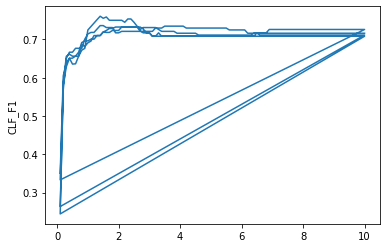

In [67]:
import matplotlib.pyplot as plt
plt.plot(cre['svc_C'].astype('float64'), cre['f1'].astype('float64'))
plt.ylabel('CLF_F1')
plt.show()


In [140]:
import numpy as np
gp = clf_acc_df.groupby('exp_id')

In [99]:
# gp.plot(kind='line',x='svc_C',y='f1')

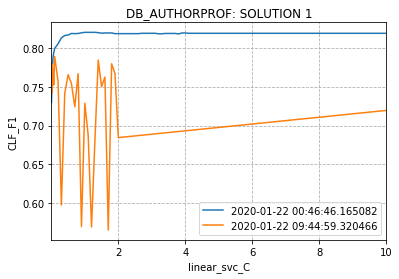

In [204]:
ax = cre.set_index('linear_svc_C').groupby('exp_id').f1.plot(legend=True)
plt.ylabel('CLF_F1')
plt.title('DB_AUTHORPROF: SOLUTION 1')
ax[0].grid(linestyle='--')
# ax[0].set_xticks(np.arange(0, 11, step=1))
# ax[0].set_ylim(0.6, 0.86)

# ax[0].lines[0].set_dashes([1, 1, 10, 2])
# ax[0].lines[1].set_dashes([1, 2 ])
# ax[0].lines[2].set_dashes([1, 2 ])
# ax[0].lines[3].set_dashes([1, 8 ])

(0.6, 0.8)

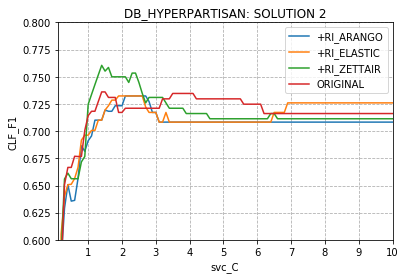

In [152]:
ax = cre.set_index('svc_C').groupby('exp_id').f1.plot(legend=True)
plt.ylabel('CLF_F1')
plt.title('DB_HYPERPARTISAN: SOLUTION 2')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_ylim(0.6, 0.8)

# ax[0].lines[0].set_dashes([1, 1, 10, 2])
# ax[0].lines[1].set_dashes([1, 2 ])
# ax[0].lines[2].set_dashes([1, 2 ])
# ax[0].lines[3].set_dashes([1, 8 ])

(0.74, 0.86)

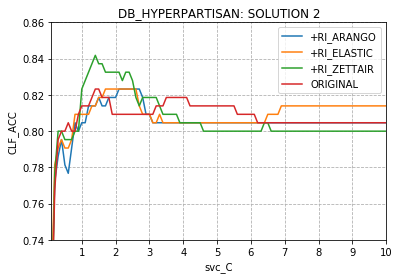

In [154]:
ax = cre.set_index('svc_C').groupby('exp_id').accuracy.plot(legend=True)
plt.ylabel('CLF_ACC')
plt.title('DB_HYPERPARTISAN: SOLUTION 2')
ax[0].grid(linestyle='--')
ax[0].set_xticks(np.arange(0, 11, step=1))
ax[0].set_ylim(0.74, 0.86)


In [89]:
cre.set_index('svc_C').groupby('exp_id').f1

In [88]:
grouped_df = cre.set_index('svc_C').groupby('exp_id')
grouped_df.groups.keys()

dict_keys(['2020-01-20 11:56:27.013101', '2020-01-20 12:17:29.856689', '2020-01-20 12:40:57.164582', '2020-01-21 01:11:16.682270'])

exp_id
2020-01-20 11:56:27.013101    AxesSubplot(0.125,0.125;0.775x0.755)
2020-01-20 12:17:29.856689    AxesSubplot(0.125,0.125;0.775x0.755)
2020-01-20 12:40:57.164582    AxesSubplot(0.125,0.125;0.775x0.755)
2020-01-21 01:11:16.682270    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

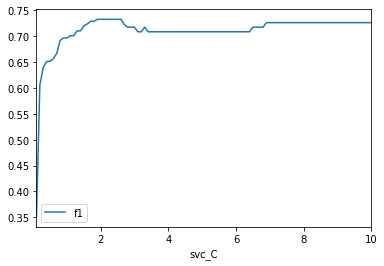

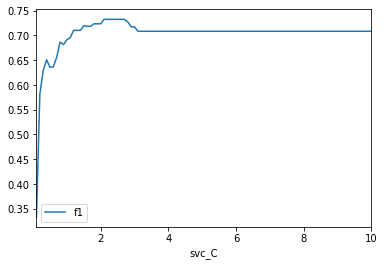

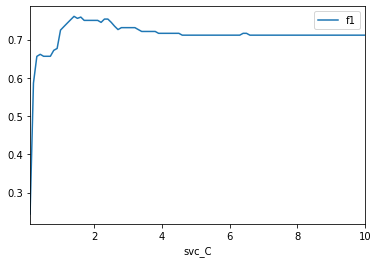

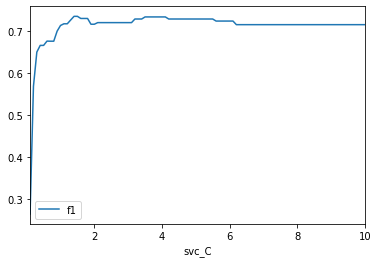

In [81]:
cre.set_index('svc_C').groupby('exp_id')[['f1','tool']].plot(legend=True)
# plt.set_title(tool)